In [170]:
from os.path import join as pjoin
import tqdm
import pandas as pd
import numpy as np
import os

import time 
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
from sklearn.model_selection import train_test_split
import gc
import torchmetrics
import matplotlib.pyplot as plt
from  torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

from sklearn.model_selection import GridSearchCV

In [112]:
label_map = {
             'abraham_grampa_simpson': 0,
             'agnes_skinner': 1,
             'apu_nahasapeemapetilon': 2,
             'barney_gumble': 3,
             'bart_simpson': 4,
             'carl_carlson': 5,
             'charles_montgomery_burns': 6,
             'chief_wiggum': 7,
             'cletus_spuckler': 8,
             'comic_book_guy': 9,
             'disco_stu': 10,
             'edna_krabappel': 11,
             'fat_tony': 12,
             'gil': 13,
             'groundskeeper_willie': 14,
             'homer_simpson': 15,
             'kent_brockman': 16,
             'krusty_the_clown': 17,
             'lenny_leonard': 18,
             'lionel_hutz': 19,
             'lisa_simpson': 20,
             'maggie_simpson': 21,
             'marge_simpson': 22,
             'martin_prince': 23,
             'mayor_quimby': 24,
             'milhouse_van_houten': 25,
             'miss_hoover': 26,
             'moe_szyslak': 27,
             'ned_flanders': 28,
             'nelson_muntz': 29,
             'otto_mann': 30,
             'patty_bouvier': 31,
             'principal_skinner': 32,
             'professor_john_frink': 33,
             'rainier_wolfcastle': 34,
             'ralph_wiggum': 35,
             'selma_bouvier': 36,
             'sideshow_bob': 37,
             'sideshow_mel': 38,
             'snake_jailbird': 39,
             'troy_mcclure': 40,
             'waylon_smithers': 41
             }

class Simpson_Train_Dataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, transform=None):
        self.image_paths = []
        self.bboxes = []
        self.labels = []
        with open(annotations_file, 'r') as f:
            for line in f:
                image_path, x1, y1, x2, y2, label = line.strip().split(',')
                image_path = os.path.join('/kaggle/input/simpsons', image_path)
                if os.path.exists(image_path):
                    self.image_paths.append(image_path)
                    self.bboxes.append([int(x1), int(y1), int(x2), int(y2)])
                    self.labels.append(label)
                    self.bbox = torch.tensor(self.bboxes)
                #else:
                    #print('Не существует файла. Путь:', image_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        bbox = self.bboxes[index]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        label = label_map[self.labels[index]]
        return image, label, bbox


class Simpson_Test_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_folder, transform=None):
        self.image_paths = []
        for image_filename in os.listdir(data_folder):
            if os.path.isfile(os.path.join(data_folder, image_filename)):
                self.image_paths.append(os.path.join(data_folder, image_filename))
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        
        if self.transform:
            image = self.transform(image)

        label = os.path.basename(image_path)
        label = '_'.join(label.split('_')[:-1])
        label = label_map[label]
        return image, label

In [113]:
size_image = 128
MEAN_IMAGE_TRANSFORM = [0.4363, 0.4328, 0.3291]
MEAN_IMAGE_STD = [0.2129, 0.2075, 0.2038]

train_transform = transforms.Compose([
    transforms.Resize((size_image, size_image)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees = 90),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(MEAN_IMAGE_TRANSFORM),
                         torch.Tensor(MEAN_IMAGE_STD))
])
test_transform = transforms.Compose([
    transforms.Resize((size_image, size_image)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees = 90),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(MEAN_IMAGE_TRANSFORM),
                         torch.Tensor(MEAN_IMAGE_STD))
])

data_set = Simpson_Train_Dataset('/kaggle/input/simpsons/annotation.txt', transform=train_transform)
test_data = Simpson_Test_Dataset('/kaggle/input/simpsons/test', transform=test_transform)

train_data, val_data = train_test_split(data_set, test_size=0.2, shuffle=True)

In [114]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, 
                                         num_workers=0, drop_last=True)

val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size, 
                                         num_workers=0, drop_last=True)

test_loader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=batch_size, 
                                           num_workers=0, drop_last=False)

In [162]:
class SimpsonsCNN(nn.Module):
    def __init__(self):
        super(SimpsonsCNN, self).__init__()

        self.conv1 = nn.Sequential( nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(16), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),  
                                    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), 
                                    nn.Dropout(0.5))
        
        self.conv2 = nn.Sequential( nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(32), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(32), nn.ReLU(),  nn.MaxPool2d(kernel_size=2, stride=2), 
                                    nn.Dropout(0.5))
        
        self.conv3 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(64), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), 
                                    nn.Dropout(0.5))
        
        self.conv4 = nn.Sequential( nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(256), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), 
                                    nn.Dropout(0.5))

        self.AApool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear( 2 * 128, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 42)
        self.Mpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.AApool(x)
        x = x.view(-1, 2 * 128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [163]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpsonsCNN()
print(count_parameters(model))
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

1812330


In [164]:
def valid_map(loader):
    classes = label_map
    classes_amount = len(label_map)
    recall = MulticlassRecall(num_classes=classes_amount, average=None)
    precision = MulticlassPrecision(num_classes=classes_amount, average=None)
    recall.to(device)
    precision.to(device)
    valid_acc = 0
    N = 0
    with torch.no_grad():
        my_loss = 0
        model.eval()
        correct = 0
        total = 0
        for sample in loader:
            images = sample[0]
            labels = sample[1]
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            recall.update(outputs, labels)
            precision.update(outputs, labels)
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            my_loss += criterion(outputs, labels).item()
            N += 1
        valid_acc = 100 * correct / total
        avr_loss = my_loss/N
    
    return avr_loss, valid_acc, recall, precision



In [165]:
learning_rate = 0.0013
weight_decay = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay = weight_decay)
scheduler = ReduceLROnPlateau(optimizer, 'min')
#scaler = torch.cuda.amp.GradScaler()
torch.cuda.empty_cache()
gc.collect()
list_loss = []
num_epochs = 100

learn_transform = transforms.Compose([ 
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(degrees = 90)
])

print(f'-----------------------------Learning begin, total of {num_epochs} epochs----------------------------\n')
for epoch in range(num_epochs):
    correct, total = 0, 0
    
    avr_loss, val_acc, val_rec, val_prec = valid_map(val_loader)
    val_rec = sum(val_rec.compute())/len(list(label_map))
    val_prec = sum(val_prec.compute())/len(list(label_map))
    print(f'\n-------------------------------------Result of Epoch {epoch}------------------------------------')
    print(f'Valid_Loss: {avr_loss:.4f}, Valid_accuracy: {val_acc:.2f}%, Valid Recall: {100*val_rec.item():.2f}%, Valid Precision: {100*val_prec.item():.2f}%')
    print(f'-------------------------------------------------------------------------------------------\n')
    
    if val_acc > 85:
        break
        
    model.train()
    
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, 
                                         num_workers=0, drop_last=True)
    
    for i, (img, labels, _) in enumerate(train_loader):
        img = img.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        img = learn_transform(img)

        with torch.cuda.amp.autocast(enabled=True):
            pred = model(img)
            loss = criterion(pred, labels)
            _, pred1 = torch.max(pred.data, 1)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
        torch.cuda.empty_cache()
        gc.collect()
        list_loss.append(loss.item())
        correct += (pred1 == labels).sum().item()
        total += labels.size(0)
        # scheduler.step(loss, epoch) # lr
        if (i + 1) % 10 == 0:
            train_acc = 100 * correct / total
            correct, total = 0, 0
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Acc: {train_acc:.2f}%')
    

-----------------------------Learning begin, total of 100 epochs----------------------------


-------------------------------------Result of Epoch 0------------------------------------
Valid_Loss: 3.7353, Valid_accuracy: 2.95%, Valid Recall: 2.38%, Valid Precision: 0.07%
-------------------------------------------------------------------------------------------

Epoch [1/100], Step [10/37], Loss: 2.6929, Acc: 11.25%
Epoch [1/100], Step [20/37], Loss: 2.6661, Acc: 15.62%
Epoch [1/100], Step [30/37], Loss: 2.4160, Acc: 20.47%

-------------------------------------Result of Epoch 1------------------------------------
Valid_Loss: 2.7750, Valid_accuracy: 20.31%, Valid Recall: 5.44%, Valid Precision: 3.91%
-------------------------------------------------------------------------------------------

Epoch [2/100], Step [10/37], Loss: 2.4514, Acc: 25.70%
Epoch [2/100], Step [20/37], Loss: 2.2401, Acc: 26.95%
Epoch [2/100], Step [30/37], Loss: 2.1819, Acc: 26.25%

------------------------------

In [166]:
print(f'------------------------------------Learning complete-----------------------------------\n')
avr_loss, test_acc, test_rec, test_prec = valid_map(test_loader)
rec = sum(test_rec.compute())/len(list(label_map))
prec = sum(test_prec.compute())/len(list(label_map))
print(f'\n-------------------------------------Result of Testing------------------------------------')
print(f'Valid_Loss: {avr_loss:.4f}, Valid_accuracy: {test_acc:.2f}%, Valid Recall: {rec.item():.2f}%, Valid Precision: {prec.item():.2f}%')
print(f'-------------------------------------------------------------------------------------------\n')

------------------------------------Learning complete-----------------------------------


-------------------------------------Result of Testing------------------------------------
Valid_Loss: 1.8611, Valid_accuracy: 69.90%, Valid Recall: 0.33%, Valid Precision: 0.32%
-------------------------------------------------------------------------------------------



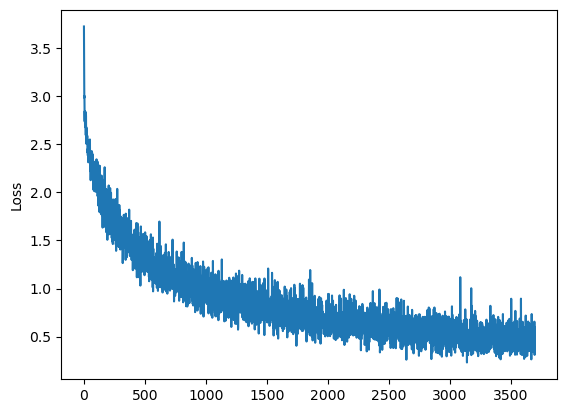

In [183]:
plt.plot(range(len(list_loss)), list_loss)
plt.ylabel('Loss')
plt.show()

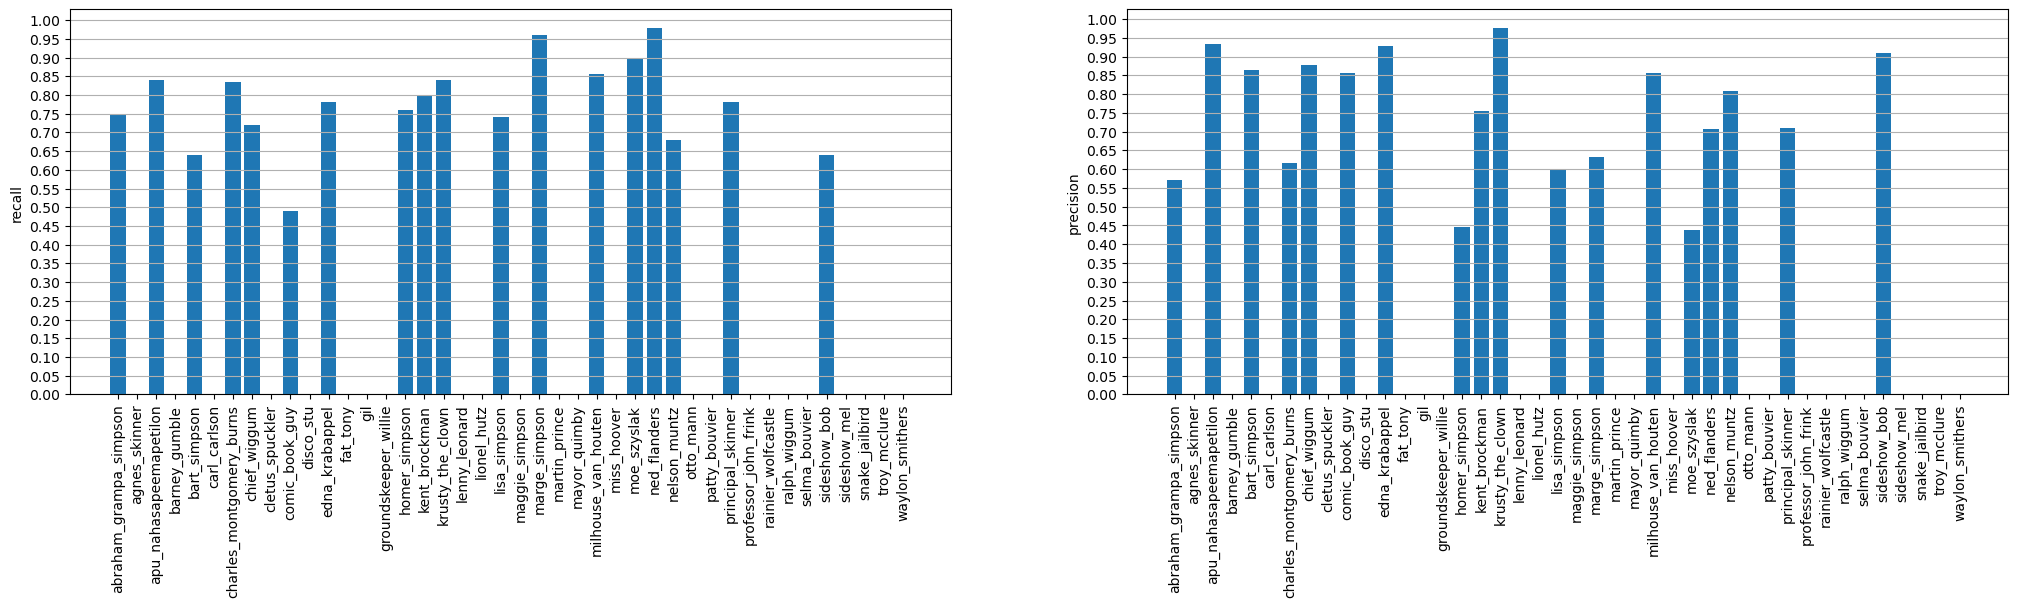

In [184]:
recall_class = {classname: val.item()
                for classname, val in zip(label_map, test_rec.compute())}
precision_class = {classname: val.item()
                   for classname, val in zip(label_map, test_prec.compute())}
metrics_per_class = {
    "recall": recall_class, "precision": precision_class}

fig, axes = plt.subplots(1, 2, figsize=(25, 5))
for (metricName, mVal), ax in zip(metrics_per_class.items(), axes):
    plt.sca(ax)
    plt.bar(mVal.keys(), mVal.values())
    plt.ylabel(metricName)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.yticks(ticks=np.arange(0, 1.01, 0.05))
plt.show()
